In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from graphviz import pipe_lines
from mlflow import catboost
from scipy.constants import precision
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Binarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc
from sklearn.preprocessing import label_binarize
import sklearn

pd.options.display.max_columns = None
sklearn.set_config(transform_output='pandas')
from sklearn.metrics import average_precision_score
import mlflow

mlflow.set_registry_uri('./mlruns')
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from catboost import CatBoostClassifier




In [5]:
df = pd.read_csv('data/Student_Performance.csv')

In [6]:
df

,Hours Studied,Previous Scores,Extracurricular Activities,Sleep Hours,Sample Question Papers Practiced,Performance Index
0,7,99,Yes,9,1,91.0
1,4,82,No,4,2,65.0
2,8,51,Yes,7,2,45.0
3,5,52,Yes,5,2,36.0
4,7,75,No,8,5,66.0
...,...,...,...,...,...,...
9995,1,49,Yes,4,2,23.0
9996,7,64,Yes,8,5,58.0
9997,6,83,Yes,8,5,74.0
9998,9,97,Yes,7,0,95.0


In [7]:
df.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800
std,2.589309,17.343152,1.695863,2.867348,19.212558
min,1.000000,40.000000,4.000000,0.000000,10.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000


In [8]:
df["Performance Index"].mean()

55.2248

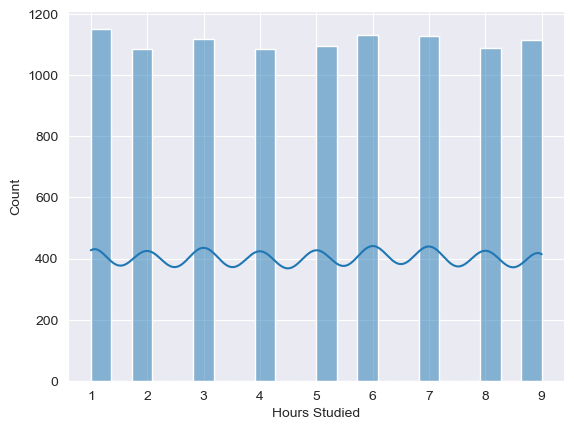

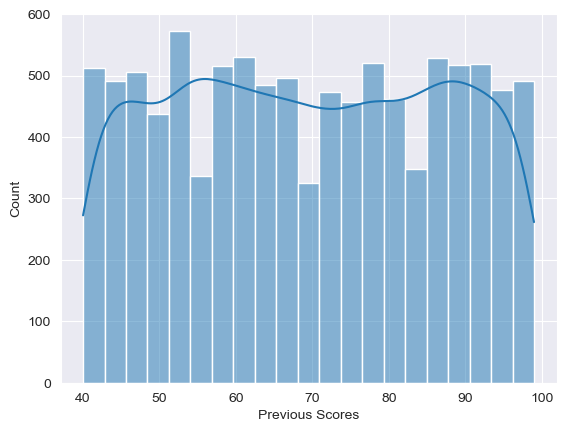

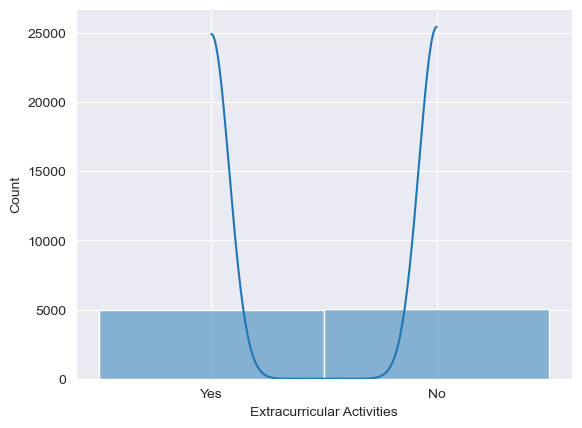

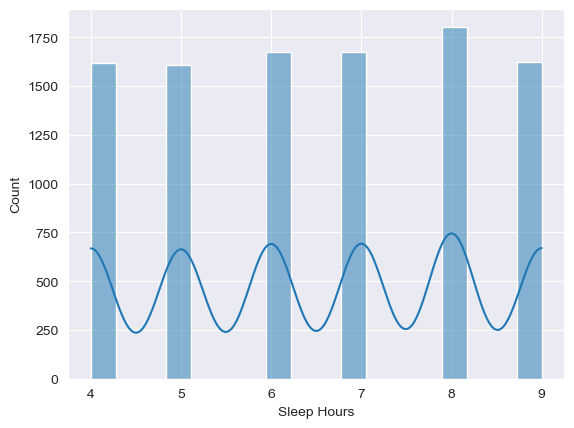

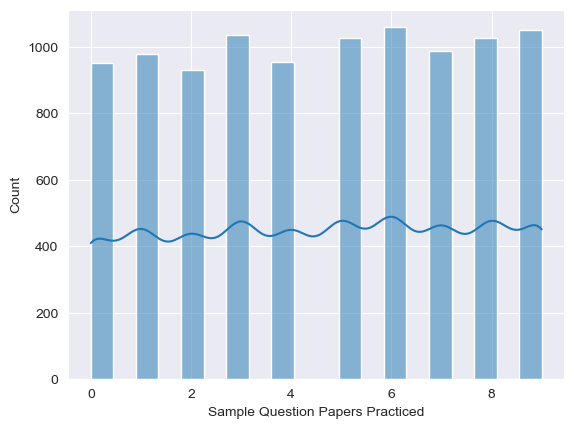

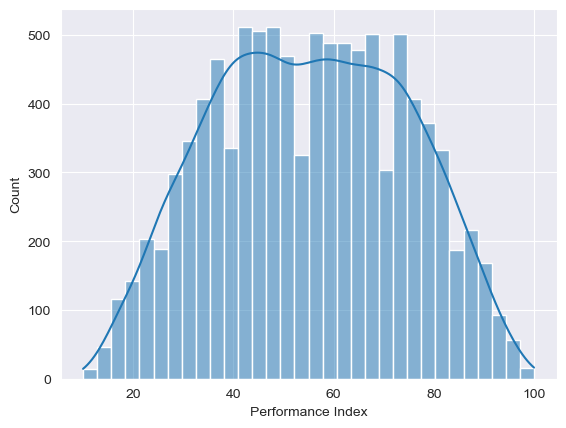

In [9]:
for col in df.columns:
    sns.histplot(data = df, x=col, kde=30)
    plt.show()

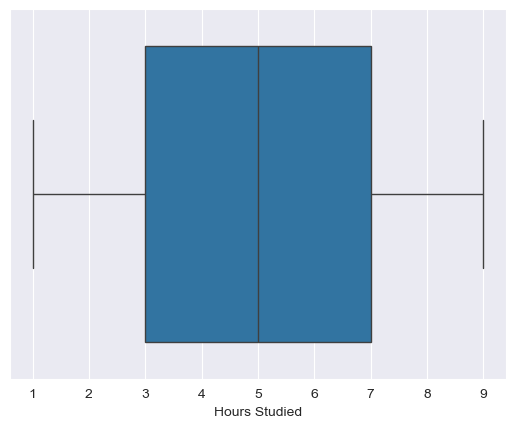

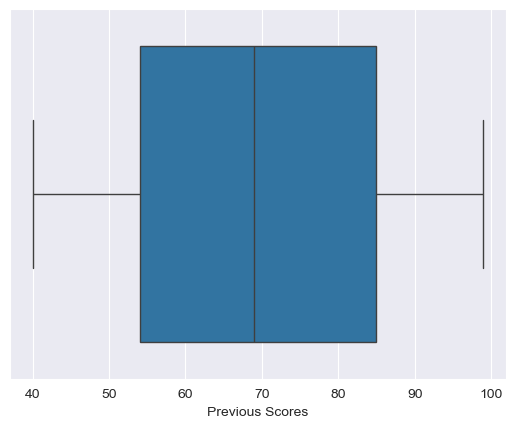

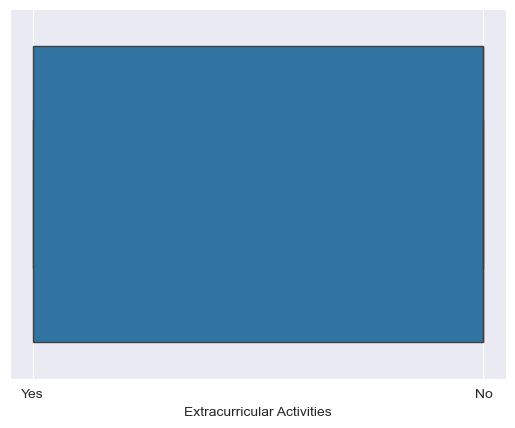

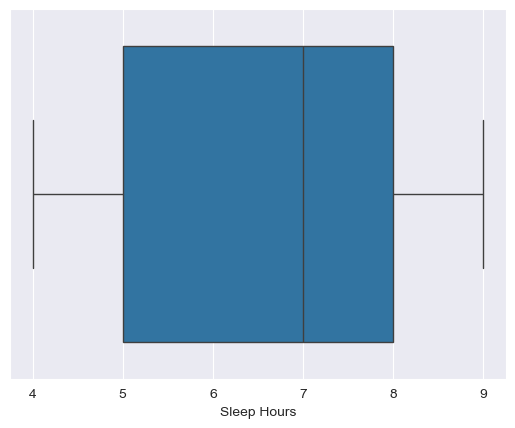

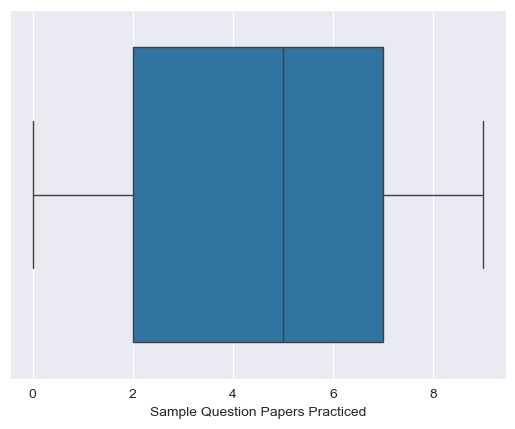

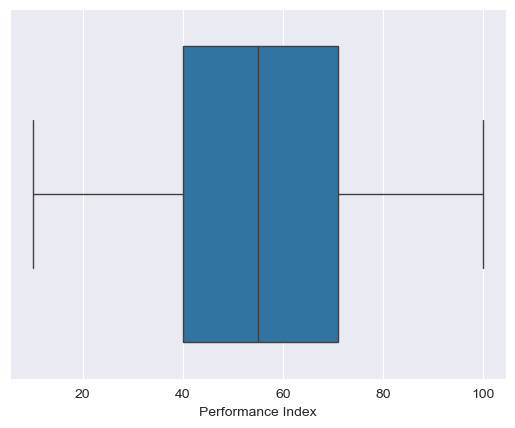

In [10]:
for col in df.columns:
    sns.boxplot(data = df, x=col)
    plt.show()

In [11]:
df.dtypes

Hours Studied                         int64
Previous Scores                       int64
Extracurricular Activities           object
Sleep Hours                           int64
Sample Question Papers Practiced      int64
Performance Index                   float64
dtype: object

In [12]:
df['Extracurricular Activities'].value_counts()

Extracurricular Activities
No     5052
Yes    4948
Name: count, dtype: int64

In [13]:
encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # Ensure dense output
encoder.fit(df[['Extracurricular Activities']])
encoded_array = encoder.transform(df[['Extracurricular Activities']])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(['Extracurricular Activities']))
df_final = pd.concat([df.drop(columns=['Extracurricular Activities']), encoded_df], axis=1)

print(df_final.head())

   Hours Studied  Previous Scores  Sleep Hours  \
0              7               99            9   
1              4               82            4   
2              8               51            7   
3              5               52            5   
4              7               75            8   

   Sample Question Papers Practiced  Performance Index  \
0                                 1               91.0   
1                                 2               65.0   
2                                 2               45.0   
3                                 2               36.0   
4                                 5               66.0   

   Extracurricular Activities_No  Extracurricular Activities_Yes  
0                            0.0                             1.0  
1                            1.0                             0.0  
2                            0.0                             1.0  
3                            0.0                             1.0  
4              

In [14]:
df_final.describe()

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Performance Index,Extracurricular Activities_No,Extracurricular Activities_Yes
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,4.992900,69.445700,6.530600,4.583300,55.224800,0.505200,0.494800
std,2.589309,17.343152,1.695863,2.867348,19.212558,0.499998,0.499998
min,1.000000,40.000000,4.000000,0.000000,10.000000,0.000000,0.000000
25%,3.000000,54.000000,5.000000,2.000000,40.000000,0.000000,0.000000
50%,5.000000,69.000000,7.000000,5.000000,55.000000,1.000000,0.000000
75%,7.000000,85.000000,8.000000,7.000000,71.000000,1.000000,1.000000
max,9.000000,99.000000,9.000000,9.000000,100.000000,1.000000,1.000000


In [15]:
x = df_final.drop(columns = ['Performance Index'])
y = df_final['Performance Index']

In [16]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [17]:
x_train

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Extracurricular Activities_No,Extracurricular Activities_Yes
9254,5,49,7,5,1.0,0.0
1561,2,48,7,6,0.0,1.0
1670,2,81,7,2,1.0,0.0
6087,2,46,6,1,1.0,0.0
6669,8,47,9,0,1.0,0.0
...,...,...,...,...,...,...
5734,8,50,6,6,0.0,1.0
5191,4,68,9,3,1.0,0.0
5390,9,48,7,6,1.0,0.0
860,1,47,9,0,1.0,0.0


In [18]:
x_test

,Hours Studied,Previous Scores,Sleep Hours,Sample Question Papers Practiced,Extracurricular Activities_No,Extracurricular Activities_Yes
6252,5,69,8,2,1.0,0.0
4684,2,46,4,8,0.0,1.0
1731,7,56,7,5,0.0,1.0
4742,6,42,8,5,0.0,1.0
4521,7,53,4,6,1.0,0.0
...,...,...,...,...,...,...
6412,2,70,7,3,1.0,0.0
8285,4,79,9,3,1.0,0.0
7853,2,40,7,2,0.0,1.0
1095,3,83,7,5,1.0,0.0


In [19]:
y_test

6252    51.0
4684    20.0
1731    46.0
4742    28.0
4521    41.0
        ... 
6412    45.0
8285    66.0
7853    16.0
1095    65.0
6929    47.0
Name: Performance Index, Length: 2000, dtype: float64

In [20]:
y_train

9254    36.0
1561    25.0
1670    59.0
6087    22.0
6669    40.0
        ... 
5734    48.0
5191    51.0
5390    44.0
860     20.0
7270    24.0
Name: Performance Index, Length: 8000, dtype: float64

In [21]:
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('power_transformer', PowerTransformer())
])  

cat_pipe = Pipeline([
    ('num', num_pipe),
    ('cat', CatBoostRegressor(iterations=500, learning_rate=0.1, depth=6, verbose=100))
])


    

    
    



NameError: name 'CatBoostRegressor' is not defined

In [ ]:
cat = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, verbose=100)
cat.fit(x_train, y_train)
y_pred = cat.predict(x_test)
y_pred_proba = cat.predict_proba(x_test)

0:	learn: 4.3346561	total: 548ms	remaining: 4m 33s
100:	learn: 2.3247188	total: 40s	remaining: 2m 37s


In [ ]:
dtc = DecisionTreeClassifier()
dtc.fit(x_train, y_train)

